In [2]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [3]:
dataset = datasets.load_dataset('bookcorpus')['train']
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [201]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
# subpath = '20240709.10:26:55' # abs_architecture, lr 1e-5~1e-3, early exploded
subpath = '20240709.11:13:35' # abs_architecture, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000

subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15
subpath = '20240711.03:33:04' # all1_layerNorm, lr 2e-5
subpath = '20240711.03:33:24' # all1_layerNorm, lr 5e-6
subpath = '20240711.03:48:45' # all1_layerNorm, lr 1e-6
subpath = '20240711.15:40:27' # bookcorpus, lr 4e-5
# subpath = '20240711.16:14:06' # multi granularity, bookcorpus, lr 4e-5 (寫錯, granularity 都很小)
# subpath = '20240711.17:01:29' # log_granularity [1,2,3,5,6,7,8,9], bookcorpus, lr 4e-5
# subpath = '20240711.17:23:01' # log_granularity [1,2,2,3,5,5,6,6], bookcorpus, lr 4e-5

weight norms, min: 0.10950691998004913, max: 0.9543152451515198
min norms: ['[PAD]', 'yin', 'moose', 'tigers', 'grenade', 'pudding', 'mario', 'commando', 'browning', 'atlas']
max norms: ['of', 'a', "'", 'in', 'it', 'was', 'the', 'to', 'and', ',']
bias norms, min: -0.14250768721103668, max: 0.13480718433856964
min norms: ['[PAD]', 'chennai', '##貝', 'ussr', '##е', '1845', 'haryana', '1883', '1709', 'migrants']
max norms: ['in', 'it', 'a', 'was', "'", 'to', 'and', 'the', ',', '.']


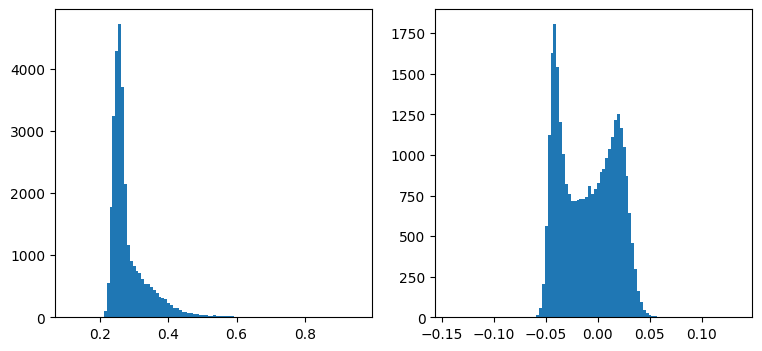

In [202]:
epoch_num = 0
batch_num = 100000


folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu')
word_reprs = model.word_embeddings().detach()

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [203]:
sentence = ['I love to [MASK].', 'Hi, how are [MASK]?']
inputs = tokenizer(sentence, return_tensors='pt', padding=True, add_special_tokens=False)
inputs

res = model(**inputs)[0]

In [204]:
ids = tokenizer.encode(sentence, add_special_tokens=False)
mask_pos = np.where([(id_ == tokenizer.vocab['[MASK]']) for id_ in ids])[0]
tokenizer.convert_ids_to_tokens(ids), mask_pos

(['i', 'love', 'to', '[MASK]', '.', 'hi', ',', 'how', 'are', '[MASK]', '?'],
 array([3, 9]))

In [205]:
n_tops = 10

score = res @ word_reprs.T
preds = score.argsort(dim=2).flip(2)[:, :, :n_tops]

In [206]:
for truth_ids, sample in zip(inputs['input_ids'], preds):
  truth_tokens = tokenizer.convert_ids_to_tokens(truth_ids)
  max_length = max([len(token) for token in truth_tokens])
  
  for token, candidates in zip(truth_tokens, sample):
    print(token.ljust(max_length), tokenizer.convert_ids_to_tokens(candidates))
  print()

i      ['love', 'i', 'want', 'do', 'have', 'hate', 'know', 'need', 'to', 'you']
love   ['love', 'want', 'do', 'need', 'you', 'to', 'have', 'know', 'feel', 'hate']
to     ['love', 'do', 'ask', 'you', 'know', 'me', 'see', 'want', 'tell', 'him']
[MASK] ['me', 'do', 'him', 'know', 'you', 'love', '.', 'ask', 'her', 'say']
.      ['it', '.', 'you', 'me', 'him', 'do', 'her', 'them', 'love', 'that']
[PAD]  ['.', 'mr', 'me', 'it', 'you', 'mrs', 'him', 'dr', 'now', 'i']

hi     [',', 'and', 'oh', 'so', 'hi', 'no', 'what', 'yes', 'to', 'god']
,      [',', 'you', 'and', 'what', 'it', 'that', 'to', 'we', 'where', 'much']
how    ['you', ',', 'what', 'we', 'they', 'it', 'why', 'that', 'are', 'how']
are    ['you', 'he', 'they', 'it', 'she', 'we', 'what', 'i', ',', 'that']
[MASK] ['you', 'it', 'that', 'he', ',', 'she', 'what', 'they', 'we', 'i']
?      ['you', 'what', 'it', 'doing', 'they', 'that', 'he', 'we', 'there', 'dead']

